## Part 2: Normalization and background removal

*by Morgane Desmau & Marco Alsina*

*Last update: May 2021*

The following notebook explains the following steps:

1. Normalization of spectra.
3. Background removal of spectra.

**Important:** This tutorial assumes you have succesfully completed the previous tutorial in the series:
- [Part 1: Basics of data processing](01.basics_data_processing.ipynb)

### 1. Checking versions

It is convenient to first check the version of `araucaria` and its dependencies, to verify that libraries are correctly loaded.

As seen in the output, this tutorial was developed with version 0.1.8. (your version could vary).

In [1]:
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version        : 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy version         : 1.19.1
Scipy version         : 1.5.2
Lmfit version         : 1.0.0
H5py version          : 3.1.0
Matplotlib version    : 3.1.1
Araucaria version     : 0.1.8


### 2. Retrieving filepath of database

`araucaria` ships with files and databases for purposes of testing and as examples.
The `testdata` module offers routines to retrieve filepaths for such databases.

In this case we will be reading and processing a minerals database measured at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. Fe_database.h5

In [1]:
# we first retrieve the proper filepath to the files and store them in a list.
from pathlib import Path
from araucaria.testdata import get_testpath

fpath = get_testpath('Fe_database.h5')

# checking that filepath is a Path class
isinstance(fpath, Path)

True

### 3. Summarizing database

`read_hdf5` allows us read a single scan from a HDF5 database, in this case ferrous sulfate measured at 20 K.

In [2]:
from araucaria.io import read_hdf5

name  = 'FeIISO4_20K'
group = read_hdf5(fpath, name)

### 2. Spectrum normalization

Normalization is an important step previous to analysis of either XANES or EXAFS spectra, and depends on the value of the absorption threshold.

`find_e0` allows to find the absorption threshold for a single scan group:

In [5]:
from araucaria.xas import find_e0

e0 = find_e0(group)
print('e0 value is %1.3f eV' % e0) 

e0 value is 7124.723 eV


We can use the previous value to normalize the spectrum and automatically update the group with the `pre_edge` function.

Note that here we use a dictionary to specifiy the normalization parameters, including the pre-edge and post-edge fitting ranges, as well as the coefficients for the pre-edge Victoreen function, and the polynomial normalization function. Please see the documentation of `pre_edge` for further details.

In [23]:
from araucaria.xas import pre_edge
from araucaria.plot import fig_pre_edge

# pre-edge parameters
pre_edge_kws = {'pre_range'  : [-160, -40],
                 'post_range': [150, 950],
                 'nvict'     : 2,
                 'nnorm'     : 3}

pre_data = pre_edge(group, e0=e0, update=True, **pre_edge_kws)
print('edge step is %1.4f a.u.' % group.edge_step)

edge step is 0.1819 a.u.


We can also plot the normalized spectrum with `fig_pre_edge`.

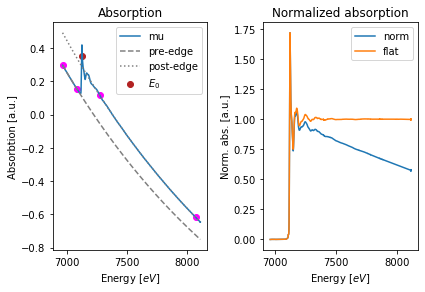

In [24]:
import matplotlib.pyplot as plt

# figure parameters
k_edge   = 7112
k_mult   = 2
fig_kws  = {'figsize'   : (12, 5.0)}   
fig_pars = {'e_range'  : (k_edge-50, k_edge+90),
           'e_ticks'   : [k_edge-51, k_edge-3, k_edge+44, k_edge+91],
           'dmu_range' : [-0.15,0.35], #need to be adapted each time
           'k_range'   : [-0.1,16.3],
           'k_mult'    : k_mult,
           'k_ticks'   : [0,2,4,6,8,10,12,14,16]
           }

fig, ax  = fig_pre_edge(group)
plt.show()

e0 value is 7084.949 eV


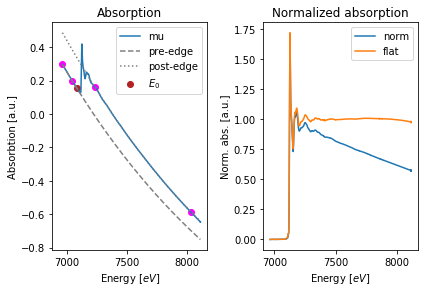

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from araucaria.xas import find_e0, pre_edge, autobk
from araucaria.plot import fig_xas_template, fig_pre_edge



# autobk parameters
autokb_kws = {'rbkg'    = 1.0,
               'k_range' = [0, 14],
               'kweight' = 2,
               'win'     = 'hanning',
               'dk'      = 0.1,
               'nfft'    = 2048,
               'kstep'   = 0.05,
               'k_std'   = None,
               'chi_std' = None,
               'nclamp'  = 2,
               'clamp_lo'= 1,
               'clamp_hi'= 1}

# Background removal of XAS scans
autbk_data = autobk(data, rbkg=rbkg, k_range=k_range, kweight=kweight, win=win, dk=dk, 
             nfft=nfft, kstep=kstep, k_std=k_std, chi_std=chi_std, nclamp=nclamp, clamp_lo=clamp_lo, 
             clamp_hi=clamp_hi, update=True)

# Plot/Check background and EXAFS
if False:
    fig, ax = fig_xas_template(panels='xe')
    line = ax[0].plot(data.energy, data.mu, label='mu')
    line = ax[0].plot(data.energy, data.bkg, label='bkg', zorder=-1)
    text = ax[0].set_ylabel('Absorbance')
    leg  = ax[0].legend()
    line = ax[1].plot(data.k, data.k**2 * data.chi, label='k^2 chi')
    leg  = ax[1].legend()
    fig.tight_layout()
    plt.show(block=False)

### 3. Data visualization

Plot data -- first visualization -- figures to present the data

AttributeError: 'Group' object has no attribute 'flat'

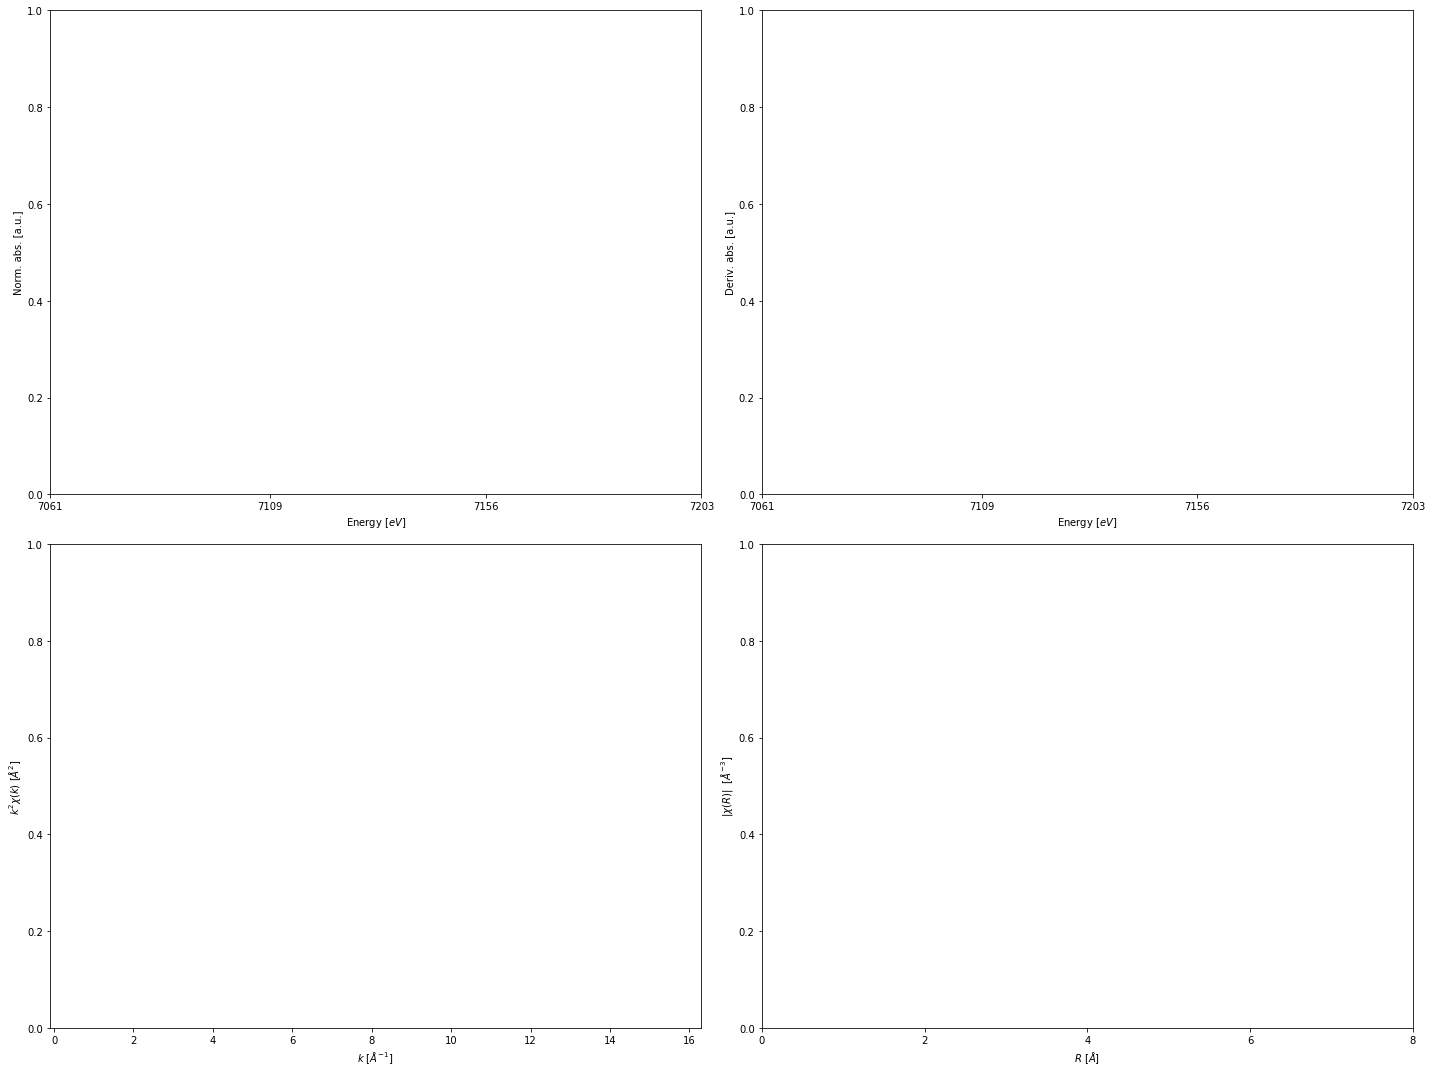

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

from araucaria import Report
from araucaria.io import read_hdf5
from araucaria.xas import find_e0, pre_edge, autobk, xftf
from araucaria.plot import fig_xas_template, fig_pre_edge

# Path to the files that contain the reference foils to align and merge
dbpath   = os.path.join('')
datnames = {'db'   :('Database_example_Fe.h5', 'Database_example_Fe.h5'),
            'names':('Goethite_20K', 'Ferrihydrite_20K')}

# Parameters normalization, background removal, foward fourrier transform
k_edge = 7112
pre_range = [-160, -40]
post_range = [140, 950]
nvict = 2
nnorm = 2 
k_range_autbk = [0, 16]
k_range_fft = [2,14.5]
kw = 2
rbkg = 1
pre_edge_kws = {'pre_range':pre_range, 'post_range': post_range, 'nvict': nvict, 'nnorm':nnorm}

# Figure parameters
fig_kws  = {'figsize'   : (20, 15.0)}  # size figure
fig_pars = {'e_range'  : (k_edge-50, k_edge+90),
           'e_ticks'   : [k_edge-51, k_edge-3, k_edge+44, k_edge+91],
           'k_range'   : [-0.1,16.3],
           'k_weight'  : kw,
           'k_ticks'   : [0,2,4,6,8,10,12,14,16],
           'r_range'   : [0, 8],
           'r_ticks'   : [0,2,4,6,8],
           'prop_cycle': [{'color'     : ['black', 'red', 'saddlebrown', 'darkorange', 
                                          'forestgreen', 'mediumturquoise', 'darkslategrey', 'darkmagenta'],
                           'linewidth' : [1, 1, 1, 1, 1, 1, 1, 1],}
                         ]}
                          
# Initializing plot axes
fig, ax = fig_xas_template(panels = 'xd/er', fig_pars = fig_pars, **fig_kws)

# Initializing report
report = Report()
col_names = ['Sample_name', 'e0 [eV]', 'Deriv_max','Emax [eV]', 'Rmax']
report.set_columns(col_names)

# Reading data
for i in range(0,len(datnames['db'])):
    data = read_hdf5(os.path.join(dbpath, datnames['db'][i]), name = datnames['names'][i])
    e0_data = find_e0(data, method='halfedge', pre_edge_kws = pre_edge_kws, update = True)
    pre_edge(data, e0 = e0_data, pre_range = pre_range, post_range = post_range, 
             nvict = nvict, update = True)
    autobk(data, rbkg = rbkg, k_range = k_range_autbk, kweight = kw, win = 'kaiser', update = True)
    xftf(data, k_range = k_range_fft, kweight = kw, update = True, win = 'kaiser')
    
    # Extracting maximum for mu, R, first derivative
    mu_max_index = data.energy[argrelextrema(data.mu, np.greater, order=100)[0][0]]
    r_max_index = data.r[argrelextrema(data.chir_mag, np.greater, order=100)[0][0]] 
    deriv_max_index = data.energy[argrelextrema(np.gradient(data.mu)/np.gradient(data.energy), np.greater, order=100)[0][0]]
    
    # Adding content to the report
    report.add_row([datnames['names'][i], e0_data, deriv_max_index, mu_max_index, r_max_index])
    
    # Plotting spectra
    ax[0,0].plot(data.energy, data.flat, label = datnames['names'][i])
    ax[0,0].legend()
    ax[0,0].axvline(mu_max_index,0,1, dashes=[3,1], color = 'black')
    ax[0,1].plot(data.energy, np.gradient(data.mu_ref)/np.gradient(data.energy), label = datnames['names'][i] )
    ax[0,1].axvline(deriv_max_index,0,1,  dashes=[3,1], color = 'black')
    ax[1,0].plot(data.k, data.k**2 * data.chi, label = datnames['names'][i] )
    ax[1,0].legend()
    ax[1,1].plot(data.r, data.chir_mag, label = datnames['names'][i]) 
    ax[1,1].legend()
    ax[1,1].axvline(r_max_index,0,1,  dashes=[3,1], color = 'black')
    #fig.suptitle('Title', y=1.02, fontsize=16)
    fig.tight_layout()
    
report.show()    
plt.show(block=False)

# Saving plot (optional)
if False:
    figpath = os.path.join('', 'Figure.pdf')
    fig.savefig(figpath, bbox_inches='tight', dpi=300)
    print ('Figure saved in %s' % figpath)

Sample_name       e0 [eV]  Deriv_max  Emax [eV]  Rmax    
Goethite_20K      7125.2   7127.3     7131       1.3499  
Ferrihydrite_20K  7124.8   7127.4     7132.6     1.3192  


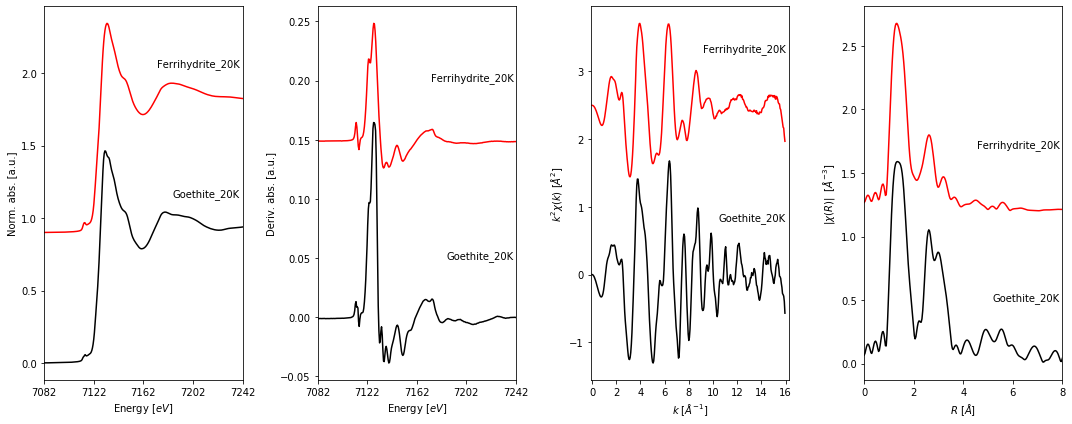

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

from araucaria import Report
from araucaria.io import read_hdf5
from araucaria.xas import find_e0, pre_edge, autobk, xftf
from araucaria.plot import fig_xas_template, fig_pre_edge

# Path to the files that contain the reference foils to align and merge
dbpath   = os.path.join('')
datnames = {'db'   :('Database_example_Fe.h5', 'Database_example_Fe.h5'),
            'names':('Goethite_20K', 'Ferrihydrite_20K')}

# Parameters normalization, background removal, foward fourrier transform
k_edge = 7112
pre_range = [-150, -50]
post_range = [150, 950]
nvict = 2
k_range_autbk = [0, 16]
k_range_fft = [2.5,12.5]
kw = 2
rbkg = 1
win = 'hanning'
pre_edge_kws = {'pre_range':pre_range, 'post_range': post_range, 'nvict': nvict, 'nnorm':nnorm}

# Figure parameters
fig_kws  = {'figsize'   : (15, 6.0)}  # size figure
steps    = [0.9, 0.15, 2.5, 1.2] 
fig_pars = {'e_range'  : (k_edge-30, k_edge+130),
           'e_ticks'   : [k_edge-30, k_edge+10, k_edge+50, k_edge+90, k_edge+130],
           'k_range'   : [-0.1,16.3],
           'k_weight'  : kw,
           'k_ticks'   : [0,2,4,6,8,10,12,14,16],
           'r_range'   : [0, 8],
           'r_ticks'   : [0,2,4,6,8],
           'prop_cycle': [{'color'     : ['black', 'red', 'saddlebrown', 'darkorange', 
                                          'forestgreen', 'mediumturquoise', 'darkslategrey', 'darkmagenta'],
                           'linewidth' : [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5],}
                         ]}

# Initializing plot axes
fig, ax = fig_xas_template(panels = 'xder', fig_pars = fig_pars, **fig_kws)

# Initializing report
report = Report()
col_names = ['Sample_name', 'e0 [eV]', 'Deriv_max','Emax [eV]', 'Rmax']
report.set_columns(col_names)
    
# Reading data
for i in range(0,len(datnames['db'])):
    data = read_hdf5(os.path.join(dbpath, datnames['db'][i]), name = datnames['names'][i])
    e0_data = find_e0(data, method='halfedge', pre_edge_kws = pre_edge_kws, update = True)
    pre_edge(data, e0 = e0_data, pre_range = pre_range, post_range = post_range, nvict = nvict, update = True)
    autobk(data, rbkg = rbkg, k_range = k_range_autbk, kweight = kw, win = win, update = True)
    xftf(data, k_range = k_range_fft, kweight = kw, update = True)
    
    # Extracting maximum for mu, R, first derivative
    mu_max_index = data.energy[argrelextrema(data.mu, np.greater, order=100)[0][0]]
    r_max_index = data.r[argrelextrema(data.chir_mag, np.greater, order=100)[0][0]] 
    deriv_max_index = data.energy[argrelextrema(np.gradient(data.mu)/np.gradient(data.energy), np.greater, order=100)[0][0]]
    
    # Adding content to the report
    report.add_row([datnames['names'][i], e0_data, deriv_max_index, mu_max_index, r_max_index])
    
    # Plotting spectra
    ax[0].plot(data.energy, i*steps[0] + data.norm) 
    ax[0].text(7240, 1.15 + i*steps[0], s = datnames['names'][i], ha='right', fontsize=10)
    ax[1].plot(data.energy, i*steps[1] + np.gradient(data.mu)/np.gradient(data.energy), 
                 label = datnames['names'][i])
    ax[1].text(7240, 0.05 + i*steps[1], s = datnames['names'][i], ha='right', fontsize=10)
    ax[2].plot(data.k, i*steps[2] + data.k**2 * data.chi, label = datnames['names'][i])
    ax[2].text(16, 0.8 + i*steps[2], s = datnames['names'][i], ha='right', fontsize=10)
    ax[3].plot(data.r, i*steps[3] + data.chir_mag, label = datnames['names'][i])
    ax[3].text(7.9, 0.5 + i*steps[3], s = datnames['names'][i], ha='right', fontsize=10)
    fig.tight_layout()
    #fig.suptitle('Title', y=1.02, fontsize=16)
    
report.show()    
plt.show(block=False)

# Saving plot (optional)
if False:
    figpath = os.path.join('figure.pdf')
    fig.savefig(figpath, bbox_inches='tight', dpi=300)
    print ('Figure saved in %s' % figpath)